In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
df = pd.read_csv('data.csv', index_col="Date")

import warnings
warnings.filterwarnings("ignore")


We can see that the close price mean and standard deviations move with time, showing non-stationarity. Additionally, the adf test concludes in non-stationarity.

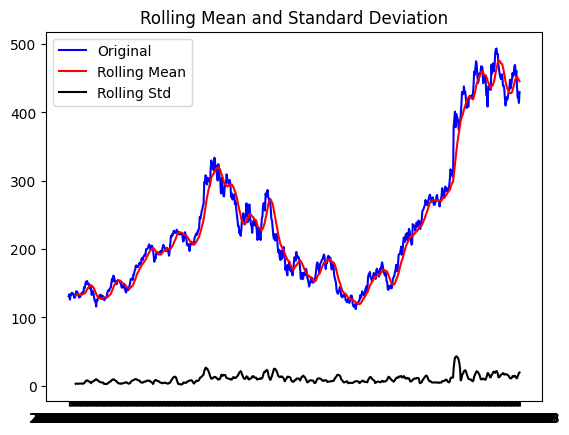

p-value: 0.9025555214270147


In [8]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    adf_test = adfuller(timeseries)
    print(f'p-value: {adf_test[1]}') #not stationary
    
test_stationarity(df["Close"])

Seasonality Decomposition
- Confirms the upward trend.
- The repeated peaks and valleys suggest a regular seasonal pattern in the data. The period appears to be consistent throughout the data, suggesting a fixed seasonality.

<Figure size 640x480 with 0 Axes>

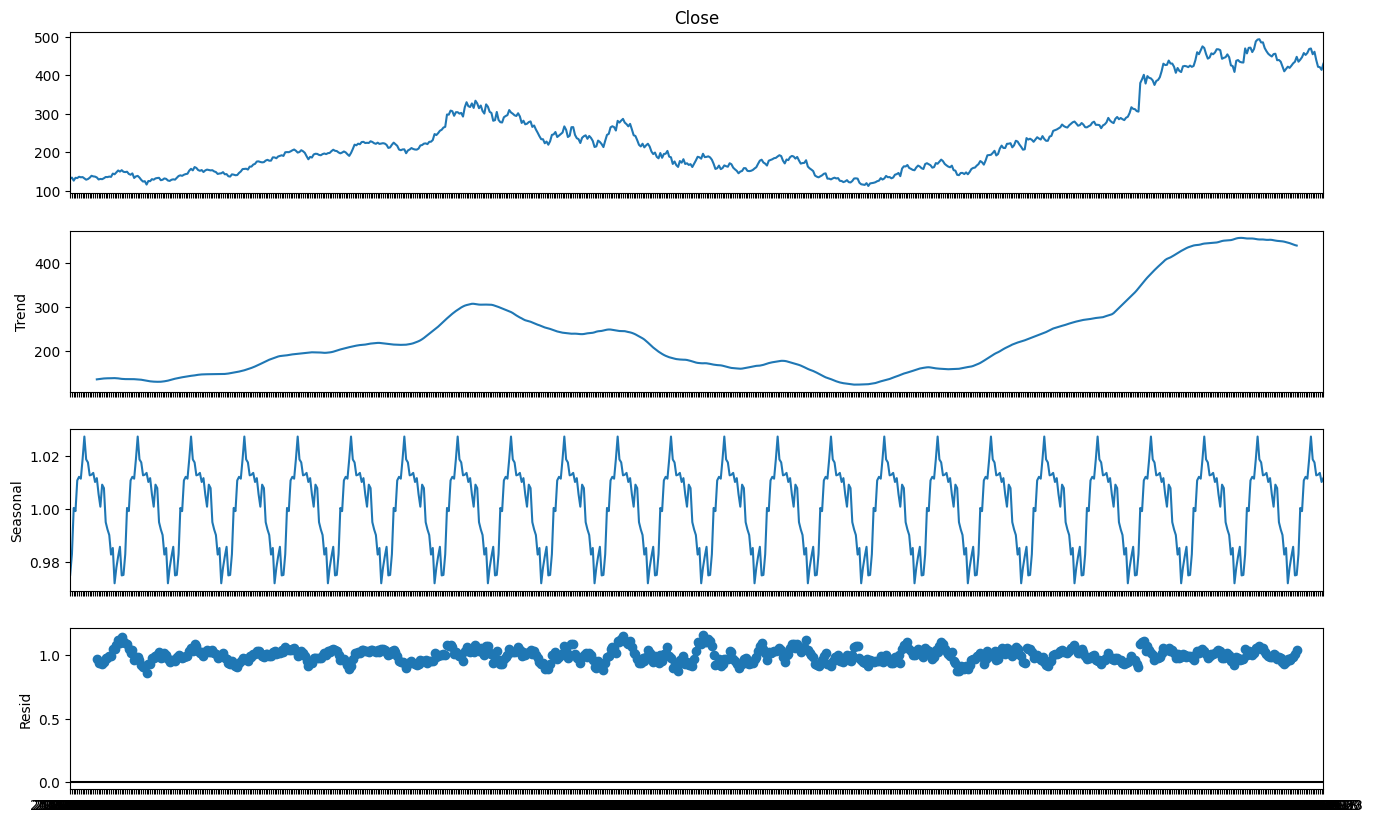

In [12]:
result = seasonal_decompose(df["Close"], model='multiplicative', period =30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

Differencing using log
- After differencing, we see that the differenced close prices are stationary. We conclude that our d =1
- From fifth PACF and ACF plots, we see a significance in the both the fifth lags.

p-value: 0.0


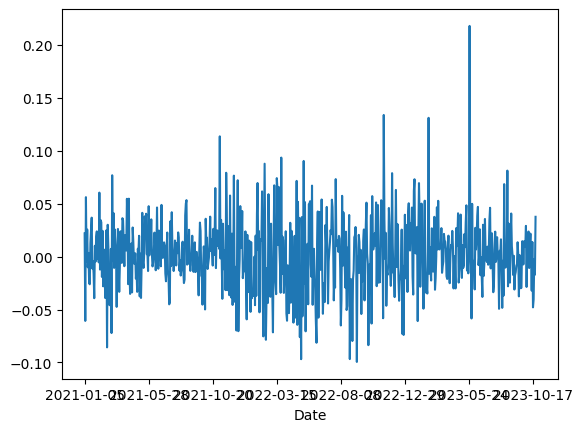

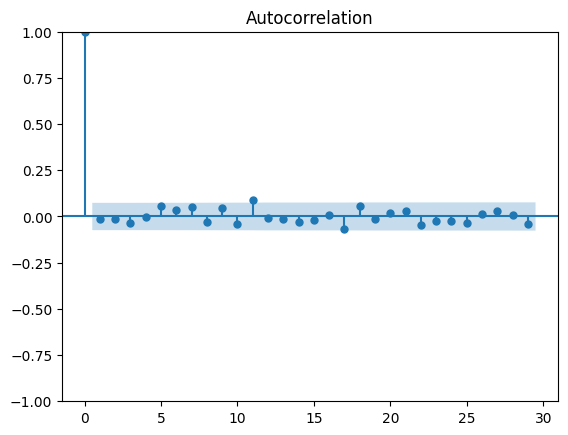

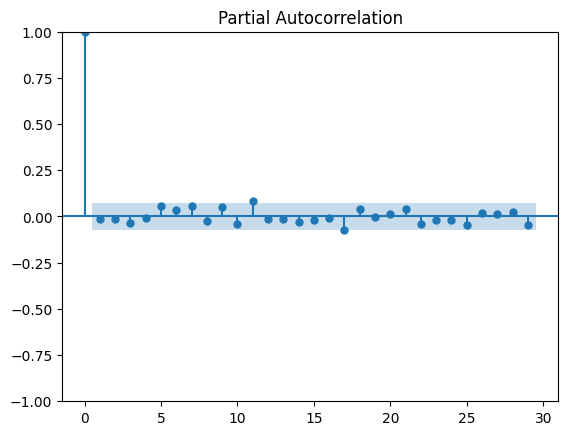

In [13]:
def make_logdiff(df):
    df_logdiff = np.log(df["Close"]) - np.log(df["Close"].shift(1))
    return df_logdiff.dropna()

df_logdiff = make_logdiff(df)
df_logdiff.plot()
acf_original = plot_acf(df_logdiff)
pacf_original = plot_pacf(df_logdiff)
adf_test = adfuller(df_logdiff)
print(f'p-value: {adf_test[1]}') #differenced data is stationary

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


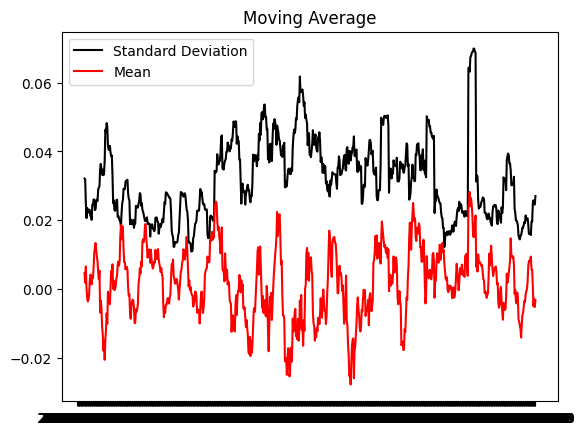

In [14]:
moving_avg = df_logdiff.rolling(12).mean()
std_dev = df_logdiff.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show() # looks p stationary to me

dataset split

In [15]:
train_data, test_data = df[3:int(len(df_logdiff)*0.9)].dropna(), df[int(len(df_logdiff)*0.9):].dropna()

Auto ARIMA

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=4357.552, Time=0.23 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=4198.867, Time=0.41 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=0.40 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=4359.392, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=4119.681, Time=0.26 sec
 ARIMA(1,1,0)(3,1,0)[7]             : AIC=4099.474, Time=0.48 sec
 ARIMA(1,1,0)(4,1,0)[7]             : AIC=4074.252, Time=0.94 sec
 ARIMA(1,1,0)(5,1,0)[7]             : AIC=4057.458, Time=1.16 sec
 ARIMA(1,1,0)(5,1,1)[7]             : AIC=inf, Time=10.35 sec
 ARIMA(1,1,0)(4,1,1)[7]             : AIC=inf, Time=6.78 sec
 ARIMA(0,1,0)(5,1,0)[7]             : AIC=4055.484, Time=0.95 sec
 ARIMA(0,1,0)(4,1,0)[7]             : AIC=4072.279, Time=0.57 sec
 ARIMA(0,1,0)(5,1,1)[7]             : AIC=inf, Time=8.60 sec
 ARIMA(0,1,0)(4,1,1)[7]             : AIC=inf, Time=4.88 sec
 ARIMA(0,1,1)(5,1,0)[7]             : AIC=4057.455, Time=

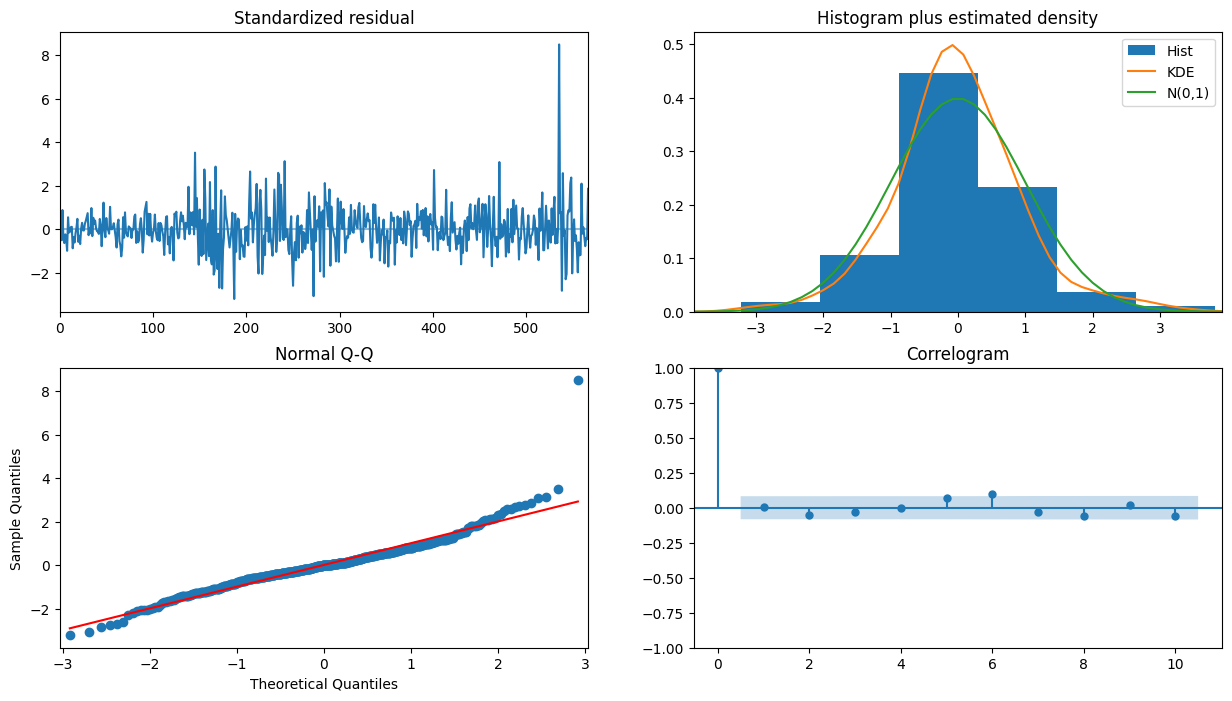

In [29]:
model_autoARIMA = auto_arima(train_data["Close"], 
                             start_p=0, start_q=0,
                             test='adf',
                             max_p=5, max_q=5, 
                             m=7,  # seasonality of 30 days for daily data
                             d=1,
                             seasonal=True, 
                             start_P=0, start_Q=0,
                             max_P=5, max_Q=5,  # setting maximum seasonal P and Q values
                             D=1,  # seasonal differencing, can let the model determine by not setting it or providing max_D
                             trace=True,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=True)

print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()


Selecting best Seasonal ARIMA parameters (137min)
- we conclude that 5,1,4,30 produced the lowest AIC.

In [16]:
import statsmodels.api as sm
import itertools
import pandas as pd

# Define the p and q values to test for seasonal_order, keeping D fixed at 1
p = q = range(0, 6)  # example range, can be modified
seasonal_pdq = [(x, 1, y, 30) for x, y in itertools.product(p, q)]

# You mentioned fixing the order at (0,1,0) and (5,1,5)
orders = [(0,1,0)]

aic_scores = []
rmse_scores = []
order_combinations = []
seasonal_order_combinations = []

for order in orders:
    for param_seasonal in seasonal_pdq:
        try:
            model = sm.tsa.SARIMAX(train_data["Close"],
                                   order=order,
                                   seasonal_order=param_seasonal,
                                   enforce_stationarity=False,
                                   enforce_invertibility=False)
            
            results = model.fit()
            
            # Calculate RMSE
            forecast = results.get_forecast(steps=len(test_data))
            fc = forecast.predicted_mean
            rmse = np.sqrt(((test_data["Close"] - fc) ** 2).mean())
            
            aic_scores.append(results.aic)
            rmse_scores.append(rmse)
            order_combinations.append(order)
            seasonal_order_combinations.append(param_seasonal)
            
        except Exception as e:
            print(f"Error with {order}x{param_seasonal}: {e}")
            continue

# Creating a DataFrame to log the results
sarima_tuning_df = pd.DataFrame({
    'order': order_combinations,
    'seasonal_order': seasonal_order_combinations,
    'AIC': aic_scores,
    'RMSE': rmse_scores
})

print(sarima_tuning_df)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.57984D+00    |proj g|=  5.35679D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      4      1     0     0   1.635D-06   3.579D+00
  F =   3.5790423952938548     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.2

 This problem is unconstrained.



At iterate    5    f=  3.20464D+00    |proj g|=  8.80880D-02

At iterate   10    f=  3.19412D+00    |proj g|=  2.00076D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     11     14      1     0     0   8.599D-07   3.194D+00
  F =   3.1941187548377825     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.05944D+00    |proj g|=  1.15612D-01

At iterate    5    f=  3.04086D+00    |proj g|=  2.96553D-02

At iterate   10    f=  3.02523D+00    |proj g|=  5.94867D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     14      1     0     0   7.152D-06   3.025D+00
  F =   3.0252337333423109     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate    5    f=  2.86307D+00    |proj g|=  1.53218D-02

At iterate   10    f=  2.85474D+00    |proj g|=  2.43123D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     15      1     0     0   5.381D-05   2.855D+00
  F =   2.8547344679431528     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.78707D+00    |proj g|=  2.41737D-01


 This problem is unconstrained.



At iterate    5    f=  2.69652D+00    |proj g|=  1.79271D-02

At iterate   10    f=  2.67905D+00    |proj g|=  3.25567D-03

At iterate   15    f=  2.67901D+00    |proj g|=  6.53413D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     21      1     0     0   1.437D-05   2.679D+00
  F =   2.6790065374881071     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.36832D+01    |proj g|=  5.37678D-02
  ys=-3.800E+01  -gs= 6.673E-01 BFGS update SKIPPED
  ys=-5.250E+01  -gs= 6.704E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      4     74      2     2     0   1.637D+04   1.519D+01
  F =   15.190034640016984     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.31002D+00    |proj g|=  4.73914D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   4.739D-06   3.310D+00
  F =   3.3100166663651964     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.25898D+00    |proj g|=  1.05457D-01

At iterate    5    f=  3.21294D+00    |proj g|=  2.60735D-02

At iterate   10    f=  3.19413D+00    |proj g|=  2.46560D-03

At iterate   15    f=  3.19412D+00    |proj g|=  7.71183D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     24      1     0     0   7.712D-06   3.194D+00
  F =   3.1941187534993252     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.



At iterate    5    f=  3.02702D+00    |proj g|=  3.16774D-02

At iterate   10    f=  3.01997D+00    |proj g|=  7.09750D-04

At iterate   15    f=  3.01995D+00    |proj g|=  7.02494D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     22      1     0     0   2.931D-07   3.020D+00
  F =   3.0199451678985847     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.87732D+00    |proj g|=  1.27122D-01


 This problem is unconstrained.



At iterate    5    f=  2.85102D+00    |proj g|=  7.57208D-03

At iterate   10    f=  2.84846D+00    |proj g|=  1.58113D-03

At iterate   15    f=  2.84840D+00    |proj g|=  3.18960D-03

At iterate   20    f=  2.84839D+00    |proj g|=  2.36641D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     24      1     0     0   3.841D-06   2.848D+00
  F =   2.8483866467168224     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.72752D+00    |proj g|=  1.72434D-01

At iterate    5    f=  2.67936D+00    |proj g|=  1.31537D-02

At iterate   10    f=  2.67132D+00    |proj g|=  2.96183D-03

At iterate   15    f=  2.67131D+00    |proj g|=  5.84034D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     19     21      1     0     0   1.018D-05   2.671D+00
  F =   2.6713055189599157     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.


  ys=-5.341E+01  -gs= 6.706E-01 BFGS update SKIPPED
  ys=-2.466E+01  -gs= 6.613E-01 BFGS update SKIPPED
  ys=-2.861E+01  -gs= 6.636E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      4     50      4     3     0   7.753D+03   1.522D+01
  F =   15.220128805287542     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.08612D+00    |proj g|=  4.98268D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      0      1      0     0     0   4.983D-06   3.086D+00
  F =   3.0861167535470524     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.08156D+00    |proj g|=  5.27126D-02

At iterate    5    f=  3.05265D+00    |proj g|=  6.11340D-02

At iterate   10    f=  3.04312D+00    |proj g|=  2.14505D-02

At iterate   15    f=  3.04264D+00    |proj g|=  2.14169D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     19      1     0     0   5.346D-06   3.043D+00
  F =   3.0426352841386763     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.05618D+00    |proj g|=  1.03922D-01

At iterate    5    f=  3.03383D+00    |proj g|=  1.27549D-02

At iterate   10    f=  3.02233D+00    |proj g|=  2.03879D-02

At iterate   15    f=  3.02005D+00    |proj g|=  1.44771D-03

At iterate   20    f=  3.01994D+00    |proj g|=  1.79951D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     31      1     0     0   9.361D-06   3.020D+00
  F =   3.0199406634502872     

CONVERG

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.87055D+00    |proj g|=  1.31296D-01

At iterate    5    f=  2.84396D+00    |proj g|=  4.26167D-03

At iterate   10    f=  2.84207D+00    |proj g|=  9.68680D-03

At iterate   15    f=  2.84198D+00    |proj g|=  1.35919D-03

At iterate   20    f=  2.84192D+00    |proj g|=  1.34146D-03

At iterate   25    f=  2.84191D+00    |proj g|=  2.56763D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     31      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.71461D+00    |proj g|=  1.72088D-01

At iterate    5    f=  2.67315D+00    |proj g|=  1.04665D-02

At iterate   10    f=  2.66631D+00    |proj g|=  1.18022D-02

At iterate   15    f=  2.66571D+00    |proj g|=  2.70307D-03

At iterate   20    f=  2.66567D+00    |proj g|=  9.10035D-04

At iterate   25    f=  2.66567D+00    |proj g|=  1.04834D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     26     30      1     0     0   

 This problem is unconstrained.


  ys=-4.589E+01  -gs= 6.693E-01 BFGS update SKIPPED
  ys=-2.531E+01  -gs= 6.617E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      5     81      3     2     0   1.928D+05   1.222D+01
  F =   12.221652456519754     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.88821D+00    |proj g|=  4.93419D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      0      1      0     0     0   4.934D-06   2.888D+00
  F =   2.8882084547527547     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.8

 This problem is unconstrained.



At iterate    5    f=  2.87708D+00    |proj g|=  6.23898D-02

At iterate   10    f=  2.87130D+00    |proj g|=  2.17523D-02
  ys=-4.684E-03  -gs= 2.464E-03 BFGS update SKIPPED

At iterate   15    f=  2.85918D+00    |proj g|=  6.94970D-03

At iterate   20    f=  2.85735D+00    |proj g|=  1.00251D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     36      1     1     0   1.975D-05   2.857D+00
  F =   2.8573493018702947     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0   

 This problem is unconstrained.



At iterate    5    f=  2.85713D+00    |proj g|=  1.19005D-02

At iterate   10    f=  2.85469D+00    |proj g|=  3.49932D-03

At iterate   15    f=  2.85440D+00    |proj g|=  6.82967D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     20      1     0     0   1.817D-06   2.854D+00
  F =   2.8543984377339822     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.87673D+00    |proj g|=  1.21347D-01

At iterate    5    f=  2.84572D+00    |proj g|=  4.47658D-03

At iterate   10    f=  2.84527D+00    |proj g|=  4.49926D-03

At iterate   15    f=  2.84509D+00    |proj g|=  7.64871D-05

At iterate   20    f=  2.84509D+00    |proj g|=  7.20472D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     22     26      1     0     0   1.366D-05   2.845D+00
  F =   2.8450941577451574     

CONVERG

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.71588D+00    |proj g|=  2.33583D-01

At iterate    5    f=  2.66823D+00    |proj g|=  2.11650D-02

At iterate   10    f=  2.66681D+00    |proj g|=  3.39296D-02

At iterate   15    f=  2.66339D+00    |proj g|=  4.50229D-03

At iterate   20    f=  2.66285D+00    |proj g|=  4.68892D-03

At iterate   25    f=  2.66279D+00    |proj g|=  2.41401D-03

At iterate   30    f=  2.66095D+00    |proj g|=  2.57485D-02

At iterate   35    f=  2.65941D+00    |proj g|=  2.55386D-03

At iterate   40    f=  2.65935D+00    |proj g|=  1.19025D-03

At iterate   45    f=  2.65935D+00    |proj g|=  3.92430D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.34908D+01    |proj g|=  6.04222D-02
  ys=-4.367E+01  -gs= 6.688E-01 BFGS update SKIPPED
  ys=-2.586E+02  -gs= 6.767E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      5     82      3     2     0   9.071D+04   1.297D+01
  F =   12.965045935658472     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.70404D+00    |proj g|=  4.69593D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      0      1      0     0     0   4.696D-06   2.704D+00
  F =   2.7040436890044415     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.70918D+00    |proj g|=  1.90158D-02


 This problem is unconstrained.



At iterate    5    f=  2.70854D+00    |proj g|=  1.37672D-02

At iterate   10    f=  2.68981D+00    |proj g|=  8.39915D-02

At iterate   15    f=  2.68497D+00    |proj g|=  1.59553D-02

At iterate   20    f=  2.68313D+00    |proj g|=  6.55560D-02

At iterate   25    f=  2.68012D+00    |proj g|=  2.18001D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     42      1     0     0   7.884D-06   2.680D+00
  F =   2.6801071917914396     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

 This problem is unconstrained.



At iterate    5    f=  2.69583D+00    |proj g|=  7.59789D-02

At iterate   10    f=  2.67714D+00    |proj g|=  2.81216D-02

At iterate   15    f=  2.67511D+00    |proj g|=  1.03563D-02

At iterate   20    f=  2.67460D+00    |proj g|=  9.72579D-03

At iterate   25    f=  2.67412D+00    |proj g|=  1.28071D-03

At iterate   30    f=  2.67412D+00    |proj g|=  3.05447D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     31     55      1     0     0   3.054D-04   2.674D+00
  F =   2.6741200187004535     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.70742D+00    |proj g|=  1.27369D-01

At iterate    5    f=  2.67294D+00    |proj g|=  2.76447D-02

At iterate   10    f=  2.67236D+00    |proj g|=  4.76387D-03

At iterate   15    f=  2.67210D+00    |proj g|=  1.82981D-03

At iterate   20    f=  2.67173D+00    |proj g|=  1.95969D-02

At iterate   25    f=  2.67149D+00    |proj g|=  1.95341D-03

At iterate   30    f=  2.67129D+00    |proj g|=  3.04888D-02

At iterate   35    f=  2.67089D+00    |proj g|=  5.87549D-03

At iterate   40    f=  2.67088D+00    |proj g|=  3.29538D-04

At iterate   45    f=  2.67088D+00    |proj g|=  1.06047D-03

At iterate   50    f=  2.67088D+00    |proj g|=  5.19102D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.71339D+00    |proj g|=  2.04574D-01

At iterate    5    f=  2.67466D+00    |proj g|=  6.34489D-02

At iterate   10    f=  2.66739D+00    |proj g|=  8.69627D-03

At iterate   15    f=  2.66418D+00    |proj g|=  1.37621D-02

At iterate   20    f=  2.66329D+00    |proj g|=  7.78261D-03

At iterate   25    f=  2.66302D+00    |proj g|=  8.75063D-03

At iterate   30    f=  2.66285D+00    |proj g|=  1.55478D-03

At iterate   35    f=  2.66279D+00    |proj g|=  3.84315D-03

At iterate   40    f=  2.66006D+00    |proj g|=  9.13759D-02

At iterate   45    f=  2.65936D+00    |proj g|=  2.61574D-03

At iterate   50    f=  2.65935D+00    |proj g|=  6.61140D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


  ys=-4.300E+01  -gs= 6.686E-01 BFGS update SKIPPED
  ys=-2.895E-01  -gs= 2.745E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10      5     81      3     2     0   2.491D+05   1.129D+01
  F =   11.294529235266214     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.47151D+00    |proj g|=  5.07225D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      0      1      0     0     0   5.072D-06   2.472D+00
  F =   2.4715065104423797     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.48281D+00    |proj g|=  8.20898D-02

At iterate    5    f=  2.47504D+00    |proj g|=  3.44451D-02

At iterate   10    f=  2.47149D+00    |proj g|=  1.97138D-02

At iterate   15    f=  2.47106D+00    |proj g|=  5.52170D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     16     19      1     0     0   5.524D-05   2.471D+00
  F =   2.4710630139682874     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.48024D+00    |proj g|=  3.92697D-02

At iterate    5    f=  2.47659D+00    |proj g|=  2.29962D-02

At iterate   10    f=  2.46999D+00    |proj g|=  1.71659D-02

At iterate   15    f=  2.46955D+00    |proj g|=  1.49296D-03

At iterate   20    f=  2.46952D+00    |proj g|=  1.37271D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     24     28      1     0     0   8.247D-06   2.470D+00
  F =   2.4695200618613447     

CONVERG

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.47730D+00    |proj g|=  8.78383D-02

At iterate    5    f=  2.46583D+00    |proj g|=  1.21172D-02

At iterate   10    f=  2.46478D+00    |proj g|=  5.11864D-03

At iterate   15    f=  2.46462D+00    |proj g|=  1.73556D-03

At iterate   20    f=  2.46456D+00    |proj g|=  9.92767D-04

At iterate   25    f=  2.46456D+00    |proj g|=  1.46889D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     28     32      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  2.46704D+00    |proj g|=  2.81093D-02

At iterate   10    f=  2.46353D+00    |proj g|=  6.09102D-03

At iterate   15    f=  2.46213D+00    |proj g|=  3.97986D-03

At iterate   20    f=  2.46183D+00    |proj g|=  1.17821D-03

At iterate   25    f=  2.46181D+00    |proj g|=  1.03924D-03

At iterate   30    f=  2.46181D+00    |proj g|=  1.57601D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     33     39      1     0     0   8.310D-06   2.462D+00
  F =   2.4618101076814232     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.


  ys=-4.282E+01  -gs= 6.686E-01 BFGS update SKIPPED
  ys=-6.171E+00  -gs= 5.480E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11      5     78      3     2     0   3.399D+05   1.041D+01
  F =   10.414877541996587     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


        order seasonal_order           AIC  RMSE
0   (0, 1, 0)  (0, 1, 0, 30)   4060.634076   NaN
1   (0, 1, 0)  (0, 1, 1, 30)   3626.130668   NaN
2   (0, 1, 0)  (0, 1, 2, 30)   3436.615054   NaN
3   (0, 1, 0)  (0, 1, 3, 30)   3245.268887   NaN
4   (0, 1, 0)  (0, 1, 4, 30)   3047.993414   NaN
5   (0, 1, 0)  (0, 1, 5, 30)  17237.499282   NaN
6   (0, 1, 0)  (1, 1, 0, 30)   3757.558900   NaN
7   (0, 1, 0)  (1, 1, 1, 30)   3628.130666   NaN
8   (0, 1, 0)  (1, 1, 2, 30)   3432.617820   NaN
9   (0, 1, 0)  (1, 1, 3, 30)   3240.070457   NaN
10  (0, 1, 0)  (1, 1, 4, 30)   3041.260459   NaN
11  (0, 1, 0)  (1, 1, 5, 30)  17273.626065   NaN
12  (0, 1, 0)  (2, 1, 0, 30)   3505.656399   NaN
13  (0, 1, 0)  (2, 1, 1, 30)   3458.348412   NaN
14  (0, 1, 0)  (2, 1, 2, 30)   3434.612712   NaN
15  (0, 1, 0)  (2, 1, 3, 30)   3234.722525   NaN
16  (0, 1, 0)  (2, 1, 4, 30)   3036.865389   NaN
17  (0, 1, 0)  (2, 1, 5, 30)  13875.353886   NaN
18  (0, 1, 0)  (3, 1, 0, 30)   3283.228388   NaN
19  (0, 1, 0)  (3, 1

Modelling ARIMA, SARIMA and SARIMAX

- Despite autoARIMA returning p=q=0, We tried p = q = 5 based on the ACF and PACF plots
- Seasonality decomposition suggested we could try SARIMA.
- Tried including the other variables for regression, but turns out there was no difference in performance.

In [17]:
import statsmodels.api as sm

# ARIMA Model
model_arima = ARIMA(train_data["Close"], order=(5,1,5))
fitted_arima = model_arima.fit()
forecast_arima = fitted_arima.get_forecast(steps=len(test_data))
fc_arima = forecast_arima.predicted_mean

# Calculate RMSE for ARIMA
rmse_arima = np.sqrt(mean_squared_error(test_data["Close"], fc_arima))
print("Root Mean Squared Error (ARIMA):", rmse_arima)


# SARIMA Model
model_sarima = sm.tsa.SARIMAX(train_data["Close"], 
                                         order=(0,1,0), 
                                         seasonal_order=(5,1,4,30))
fitted_sarima = model_sarima.fit()
forecast_sarima = fitted_sarima.get_forecast(steps=len(test_data))
fc_sarima = forecast_sarima.predicted_mean
rmse_sarima = np.sqrt(mean_squared_error(test_data["Close"], fc_sarima))
print("Root Mean Squared Error (SARIMA):", rmse_sarima)






Root Mean Squared Error (ARIMA): 26.510286986940717
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.42816D+00    |proj g|=  1.46167D-01


 This problem is unconstrained.



At iterate    5    f=  3.39086D+00    |proj g|=  2.50114D-02

At iterate   10    f=  3.37996D+00    |proj g|=  2.40051D-02

At iterate   15    f=  3.37951D+00    |proj g|=  1.00280D-02

At iterate   20    f=  3.37893D+00    |proj g|=  9.16638D-03

At iterate   25    f=  3.37869D+00    |proj g|=  2.72005D-03

At iterate   30    f=  3.37831D+00    |proj g|=  1.31796D-02

At iterate   35    f=  3.37824D+00    |proj g|=  2.74926D-03

At iterate   40    f=  3.37823D+00    |proj g|=  5.27648D-04

At iterate   45    f=  3.37822D+00    |proj g|=  3.35898D-03

At iterate   50    f=  3.37810D+00    |proj g|=  1.00767D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

KeyboardInterrupt: 

In [21]:
# SARIMAX Model
endog = train_data['Close']
exog = train_data.drop('Close', axis=1).shift(1).fillna(method='bfill', inplace=True)  # removing the 'Close' column to use the rest as exogenous variables
exog_test = test_data.drop('Close', axis=1).shift(1).fillna(method='bfill', inplace=True) # give the preceding day's data for each day

model_sarimax = sm.tsa.SARIMAX(endog, exog=exog, order=(0,1,0), seasonal_order=(5,1,4,30))
fitted_sarimax = model_sarimax.fit(disp=False)
forecast_sarimax = fitted_sarimax.get_forecast(steps=len(test_data), exog=exog_test)
fc_sarimax = forecast_sarimax.predicted_mean

# Calculate RMSE for SARIMAX
rmse_sarimax = np.sqrt(mean_squared_error(test_data["Close"], fc_sarimax))
print("Root Mean Squared Error (ARIMAX):", rmse_sarimax)


Root Mean Squared Error (ARIMAX): 24.938329171790233


SARIMA/SARIMAX performed the best at RMSE:24.9, followed by ARIMA with RMSE: 26.5

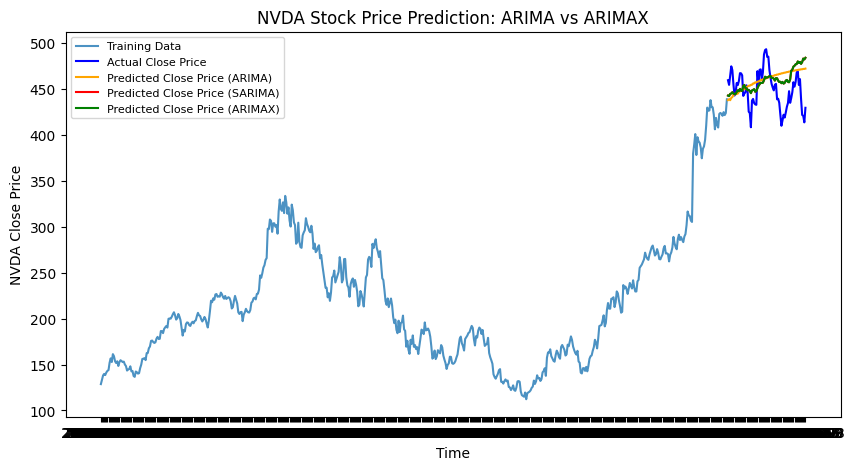

In [22]:
# Plot both ARIMA and SARIMAX predictions together
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data["Close"], label='Training Data', alpha=0.8)
plt.plot(test_data["Close"], color='blue', label='Actual Close Price')
plt.plot(fc_arima, color='orange', label='Predicted Close Price (ARIMA)')
plt.plot(fc_sarima, color='red', label='Predicted Close Price (SARIMA)')
plt.plot(fc_sarimax, color='green', label='Predicted Close Price (ARIMAX)')
plt.title('NVDA Stock Price Prediction: ARIMA vs ARIMAX')
plt.xlabel('Time')
plt.ylabel('NVDA Close Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Predictions for submission:

- if the last day of data is the submission date, then the following prediction_df will be the predicted close prices of the next 14 days.

In [41]:
forecast_sarima_extended = fitted_sarima.get_forecast(steps=len(test_data) + 15)
fc_sarima_extended = forecast_sarima_extended.predicted_mean

# Save the last 14 days of predictions in prediction_df
prediction_df = pd.DataFrame(fc_sarima_extended[-15:])
print(prediction_df)

     predicted_mean
647      483.175950
648      482.431553
649      485.048643
650      484.213959
651      479.504755
652      480.067486
653      480.965173
654      479.952542
655      481.551559
656      478.947536
657      477.688417
658      477.475200
659      479.345824
660      477.190665
661      478.562780


References:
- https://www.kaggle.com/code/nageshsingh/stock-market-forecasting-arima/notebook
- https://otexts.com/fpp2/seasonal-arima.html
